In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

from IPython.display import Image

### get primary production data

In [2]:
csv_file = '/glade/work/kristenk/BATS/bats_primary_production.csv'
primaryprod_df = pd.read_csv(csv_file)
#primaryprod_df

#### This csv file was preprocessed via `process_primary_production.sh`

### Comments
 
filename:bats_primary_production.dat
contains BATS primary production  rates for years 1988 - 2021

### NOTE:

The cruise list contains all of the cruises within the specified limits.
However, not all cruises may contain data for the parameters selected.

### Variable list

Id     = Sample Id                                                                               
 A unique bottle id which identifies cruise, cast and bottle number
 9 digit number 
 ```
 !####$$@@, where
 !   = Cruise type, 1=BATS core, 2=BATS bloom a, and 3=BATS bloom b, ect.
 #### = Cruise number
 $$  = Cast Number, 1-80=CTD casts, 81-99=Hydrocasts (i.e. 83=Hydrocast number 3)
 @@  = Bottle number
 e.g., 100488108 is BATS core 48, Hydrocast 1, Bottle 8
 ```
Id        = Sample Id                                                                               
yymmdd_in    = Year Month Day -deploy
yyymmdd_out  = Year month Day - recover
decy_in      = dec_year deploy
decy_out     = dec_year_recover
hhmm_in      = time_deploy
hhmm_out     = time_recover                                                        
Lat_in       = Latitude of water collection -deploy
Lon_out      = Longitude of water collection - recover
QF           = Nisken Flag                                                                        
dep1         = Collection depth (m)
Pres         = pressure (dbar)   
temp         = CTD temp (C)         
salt         = salinity from goflo bottle or CTD .                                                          
lt1          = 14C Primary Production light bottle #1 (mgC/m^3/day)                                    
lt2          = 14C Primary Production light bottle #2 (mgC/m^3/day)                                    
lt3          = 14C Primary Production light bottle #3 (mgC/m^3/day)                                    
dark         = 14C Primary Production dark bottle (mgC/m^3/day)                                        
t0           = 14C Primary Production Time zero (mgC/m^3/day)                                          
pp           = Primary Production Mean Light values - Dark value (mgC/m^3/day)       

In [3]:
primaryprod_df

,Id,yymmdd_in,yymmdd_out,decy_in,decy_out,hhmm_in,hhmm_out,Lat_in,Lat_out,Long_in,...,dep1,pres,temp,salt,lt1,lt2,lt3,dark,t0,pp
0,1000308101,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,5.0,-999.0,-999.000,-999.000,7.21,6.59,-999.00,0.75,1.26,6.15
1,1000308102,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,25.0,-999.0,-999.000,-999.000,6.00,-999.00,-999.00,-999.00,1.97,-999.00
2,1000308103,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,50.0,-999.0,-999.000,-999.000,3.62,2.69,3.19,1.02,1.57,2.15
3,1000308104,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,75.0,-999.0,-999.000,-999.000,2.21,1.40,1.55,1.43,1.47,0.29
4,1000308105,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,100.0,-999.0,-999.000,-999.000,1.15,1.78,8.48,0.95,1.46,2.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,1038801907,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,58.8,59.3,22.553,36.567,3.34,3.25,3.30,0.87,0.77,2.43
3480,1038801909,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,80.0,80.6,22.534,36.571,1.37,1.45,1.42,0.80,0.72,0.61
3481,1038801911,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,99.9,100.6,22.352,36.586,0.77,0.85,0.73,0.87,0.60,-0.09
3482,1038801913,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,118.7,119.6,22.270,36.617,0.57,1.00,0.75,0.67,30.95,0.10


In [4]:
primaryprod_df['date'] = pd.to_datetime(primaryprod_df['yymmdd_in'], format='%Y%m%d')
primaryprod_df['year']= primaryprod_df['date'].dt.year
primaryprod_df['month']= primaryprod_df['date'].dt.month
primaryprod_df['day']= primaryprod_df['date'].dt.day

In [5]:
primaryprod_df

,Id,yymmdd_in,yymmdd_out,decy_in,decy_out,hhmm_in,hhmm_out,Lat_in,Lat_out,Long_in,...,lt1,lt2,lt3,dark,t0,pp,date,year,month,day
0,1000308101,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,7.21,6.59,-999.00,0.75,1.26,6.15,1988-12-18,1988,12,18
1,1000308102,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,6.00,-999.00,-999.00,-999.00,1.97,-999.00,1988-12-18,1988,12,18
2,1000308103,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,3.62,2.69,3.19,1.02,1.57,2.15,1988-12-18,1988,12,18
3,1000308104,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,2.21,1.40,1.55,1.43,1.47,0.29,1988-12-18,1988,12,18
4,1000308105,19881218,19881218,1988.965,-999.000,-999,-999,31.669,-999.000,64.049,...,1.15,1.78,8.48,0.95,1.46,2.85,1988-12-18,1988,12,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,1038801907,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,3.34,3.25,3.30,0.87,0.77,2.43,2021-12-14,2021,12,14
3480,1038801909,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,1.37,1.45,1.42,0.80,0.72,0.61,2021-12-14,2021,12,14
3481,1038801911,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,0.77,0.85,0.73,0.87,0.60,-0.09,2021-12-14,2021,12,14
3482,1038801913,20211214,20211214,2021.952,347.332,758,840,31.666,31.666,64.170,...,0.57,1.00,0.75,0.67,30.95,0.10,2021-12-14,2021,12,14


### turn all -999 to nans

In [6]:
primaryprod_df = primaryprod_df.replace(-999.,np.nan)

### Make a mean of light bottle production

In [7]:
primaryprod_df['lt_mean'] = primaryprod_df[['lt1','lt2','lt3']].mean(axis=1)

### Drop unnessary columns

In [8]:
primaryprod_df = primaryprod_df.drop(columns=['lt1','lt2','lt3'])

In [9]:
primaryprod_df = primaryprod_df.drop(columns=['yymmdd_out','decy_out','hhmm_in','hhmm_out','Lat_out','Long_out'])

In [10]:
primaryprod_df

,Id,yymmdd_in,decy_in,Lat_in,Long_in,QF,dep1,pres,temp,salt,dark,t0,pp,date,year,month,day,lt_mean
0,1000308101,19881218,1988.965,31.669,64.049,2,5.0,NaN,NaN,NaN,0.75,1.26,6.15,1988-12-18,1988,12,18,6.900000
1,1000308102,19881218,1988.965,31.669,64.049,2,25.0,NaN,NaN,NaN,NaN,1.97,NaN,1988-12-18,1988,12,18,6.000000
2,1000308103,19881218,1988.965,31.669,64.049,2,50.0,NaN,NaN,NaN,1.02,1.57,2.15,1988-12-18,1988,12,18,3.166667
3,1000308104,19881218,1988.965,31.669,64.049,2,75.0,NaN,NaN,NaN,1.43,1.47,0.29,1988-12-18,1988,12,18,1.720000
4,1000308105,19881218,1988.965,31.669,64.049,2,100.0,NaN,NaN,NaN,0.95,1.46,2.85,1988-12-18,1988,12,18,3.803333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,1038801907,20211214,2021.952,31.666,64.170,1,58.8,59.3,22.553,36.567,0.87,0.77,2.43,2021-12-14,2021,12,14,3.296667
3480,1038801909,20211214,2021.952,31.666,64.170,1,80.0,80.6,22.534,36.571,0.80,0.72,0.61,2021-12-14,2021,12,14,1.413333
3481,1038801911,20211214,2021.952,31.666,64.170,1,99.9,100.6,22.352,36.586,0.87,0.60,-0.09,2021-12-14,2021,12,14,0.783333
3482,1038801913,20211214,2021.952,31.666,64.170,1,118.7,119.6,22.270,36.617,0.67,30.95,0.10,2021-12-14,2021,12,14,0.773333


In [11]:
dates = primaryprod_df.date.unique()

In [12]:
len(dates)

433

### integrate pp first

In [13]:
column_names = ["year", "month","day", "NPP (mg/m2/d)", "PP (mg/m2/d)"]

new_NPP_df = pd.DataFrame(columns = column_names)

#cycle through the dates and make an average of light bottle NPP, 
for date in dates:
    
    selection = primaryprod_df[(primaryprod_df['date'] == date)]

    year = selection.year.mean()
    month = selection.month.mean()
    day = selection.day.mean()

    selection.sort_values(by=['dep1'])

    meas_no = len(selection)
    depths = np.asarray(selection['dep1'])
    lt_vals = np.asarray(selection['lt_mean'])
    pp_vals = np.asarray(selection['pp'])

    #### first integrate npp
    right_sum = 0.
    left_sum =0.

    for step in np.arange(0,meas_no,1):

        if step == 0:
            dz = depths[0] #diff between first measurement and the surface
            left_sum = left_sum + dz * lt_vals[step]
            right_sum = left_sum #assume well mixed above shallowest measurement
        else:

            dz = depths[step] - depths[step-1]
            right_sum = right_sum + dz * lt_vals[step - 1]
            left_sum = left_sum + dz * lt_vals[step]

    riemann_sum = (right_sum+left_sum)/2
    #print(riemann_sum, year, month, day)

    ### now do pp
    right_sum = 0.
    left_sum =0.

    for step in np.arange(0,meas_no,1):

        if step == 0:
            dz = depths[0] #diff between first measurement and the surface
            left_sum = left_sum + dz * pp_vals[step]
            right_sum = left_sum #assume well mixed above shallowest measurement
        else:

            dz = depths[step] - depths[step-1]
            right_sum = right_sum + dz * pp_vals[step - 1]
            left_sum = left_sum + dz * pp_vals[step]

    riemann_sum2 = (right_sum+left_sum)/2

    
    
    

    new_NPP_df = new_NPP_df.append({'year' : year, 'month' : month, 'day' : day, 'NPP (mg/m2/d)' : riemann_sum, 'PP (mg/m2/d)' : riemann_sum2},  
    ignore_index = True) 

In [14]:
new_NPP_df

,year,month,day,NPP (mg/m2/d),PP (mg/m2/d)
0,1988.0,12.0,18.0,457.941667,NaN
1,1989.0,1.0,27.0,268.590000,249.4550
2,1989.0,2.0,19.0,847.289167,NaN
3,1989.0,3.0,26.0,238.931667,210.8750
4,1989.0,4.0,17.0,241.496667,210.9350
...,...,...,...,...,...
428,2021.0,8.0,20.0,592.243667,474.2755
429,2021.0,9.0,13.0,389.069500,261.2965
430,2021.0,10.0,6.0,490.401000,398.0185
431,2021.0,11.0,18.0,523.223333,386.1990


### make a monthly climatology to show seasonal cycle of NPP

In [15]:
selection = new_NPP_df[(new_NPP_df['month']==1)]
selection.dtypes

year             float64
month            float64
day              float64
NPP (mg/m2/d)    float64
PP (mg/m2/d)     float64
dtype: object

In [16]:
column_names = ["month","NPP (mg/m2/d)","NPP st dev (mg/m2/d)","PP (mg/m2/d)","PP st dev (mg/m2/d)"]

NPP_monthly_clim_df = pd.DataFrame(columns = column_names)

for month in np.arange(1,13,1):

    selection = new_NPP_df[(new_NPP_df['month']==month)]

    if (len(selection)==0):
        print('missing ', month)

    else:

        npp = selection['NPP (mg/m2/d)'].mean()
        sd_npp = selection['NPP (mg/m2/d)'].std()
        
        pp = selection['PP (mg/m2/d)'].mean()
        sd_pp = selection['PP (mg/m2/d)'].std()

        NPP_monthly_clim_df = NPP_monthly_clim_df.append({'month' : month, 'NPP (mg/m2/d)' : npp, 'NPP st dev (mg/m2/d)' : sd_npp,
                                                         'PP (mg/m2/d)' : pp, 'PP st dev (mg/m2/d)' : sd_pp},  ignore_index = True)
        
NPP_monthly_clim_df

,month,NPP (mg/m2/d),NPP st dev (mg/m2/d),PP (mg/m2/d),PP st dev (mg/m2/d)
0,1.0,577.987980,523.319201,415.694980,151.271729
1,2.0,750.829404,412.033555,589.111083,236.703324
2,3.0,840.744406,691.567669,568.372144,302.018559
3,4.0,739.541817,697.856056,596.559449,562.808381
4,5.0,672.338344,756.505191,438.613694,183.762952
5,6.0,524.693917,116.957483,431.350673,102.293072
6,7.0,550.626763,165.270344,441.546076,157.434884
7,8.0,520.645741,190.099114,405.476241,123.280434
8,9.0,494.199506,159.638093,387.876241,137.344857
9,10.0,469.133580,234.599997,342.668914,113.521383


<AxesSubplot:>

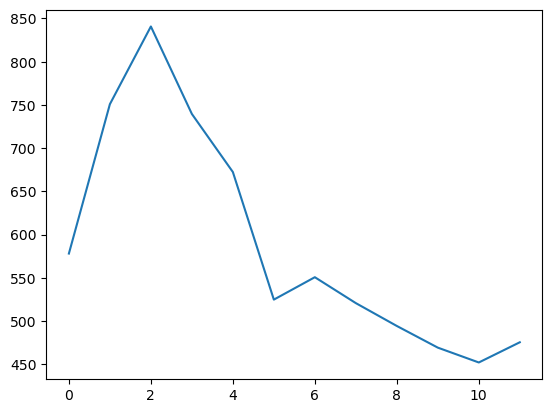

In [17]:
NPP_monthly_clim_df['NPP (mg/m2/d)'].plot()

<AxesSubplot:>

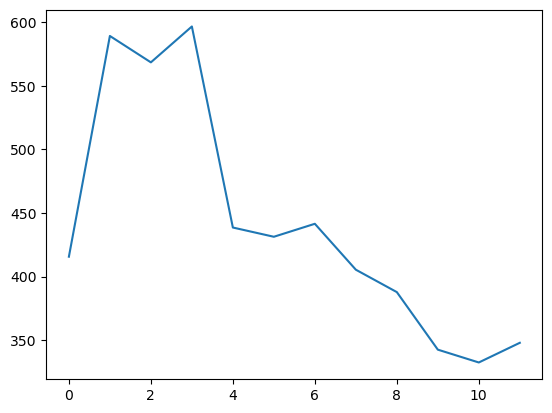

In [18]:
NPP_monthly_clim_df['PP (mg/m2/d)'].plot()

In [19]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
xvals = np.arange(1,13,1)

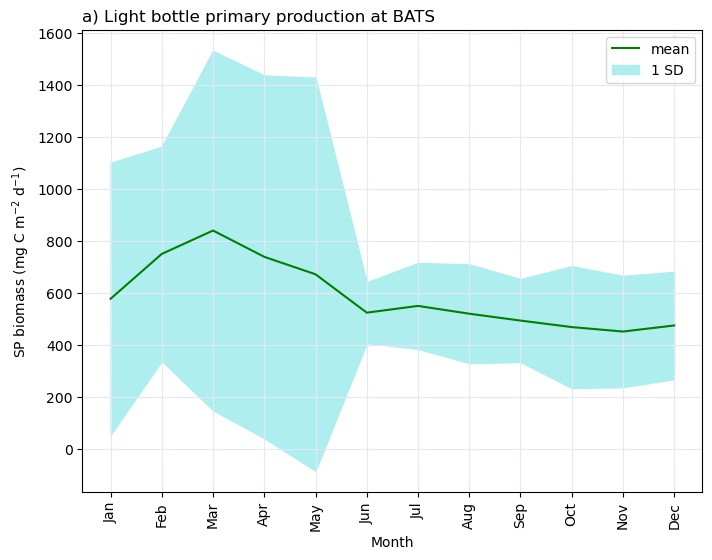

In [20]:
fig = plt.figure(figsize=(8,6))

######################################################## 

ax1 = fig.add_subplot(1,1,1)
ax1.set_title('a) Light bottle primary production at BATS',fontsize=12,loc='left')
ax1.set_ylabel('SP biomass (mg C m$^{-2}$ d$^{-1}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.plot(xvals,NPP_monthly_clim_df['NPP (mg/m2/d)'], 
         color='green', label='mean', lw=1.5)
error = NPP_monthly_clim_df['NPP st dev (mg/m2/d)']
ax1.fill_between(xvals, NPP_monthly_clim_df['NPP (mg/m2/d)']-error, 
                 NPP_monthly_clim_df['NPP (mg/m2/d)']+error,color='paleturquoise', label = '1 SD')
plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()

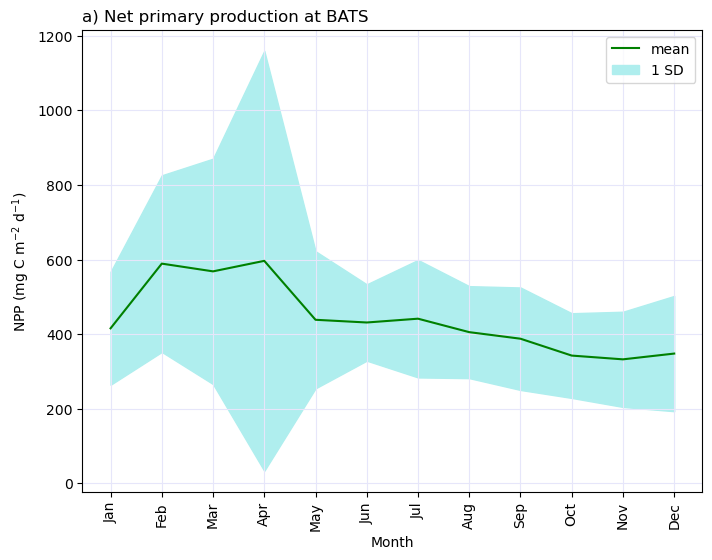

In [21]:
fig = plt.figure(figsize=(8,6))

######################################################## 

ax1 = fig.add_subplot(1,1,1)
ax1.set_title('a) Net primary production at BATS',fontsize=12,loc='left')
ax1.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.plot(xvals,NPP_monthly_clim_df['PP (mg/m2/d)'], 
         color='green', label='mean', lw=1.5)
error = NPP_monthly_clim_df['PP st dev (mg/m2/d)']
ax1.fill_between(xvals, NPP_monthly_clim_df['PP (mg/m2/d)']-error, 
                 NPP_monthly_clim_df['PP (mg/m2/d)']+error,color='paleturquoise', label = '1 SD')
plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()

### Make monthly NPP timeseries, where missing months are replaced by climatology

In [22]:
column_names = ["year", "month", "deciyear", "NPP (mg/m2/d)"]

new_NPP_df2 = pd.DataFrame(columns = column_names)

for year in np.arange(1989,2022,1):
    for month in np.arange(1,13,1):
        
        deciyear = year + month/12. - 1/24.
        
        selection = new_NPP_df[(new_NPP_df['year']==year) &
                              (new_NPP_df['month']==month)]

        if (len(selection)==0):
            #print('missing ', month, year)
            clim = NPP_monthly_clim_df[(NPP_monthly_clim_df.month == month)]
            npp = clim['NPP (mg/m2/d)'].mean()
            new_NPP_df2 = new_NPP_df2.append({'year' : year, 'month' : month, "deciyear": deciyear, 'NPP (mg/m2/d)' : npp},  ignore_index = True)

            
        elif(len(selection)>=1):
            
            npp = selection['NPP (mg/m2/d)'].mean()
            
            new_NPP_df2 = new_NPP_df2.append({'year' : year, 'month' : month, "deciyear": deciyear, 'NPP (mg/m2/d)' : npp},  ignore_index = True)


In [23]:
new_NPP_df2[15:45]

,year,month,deciyear,NPP (mg/m2/d)
15,1990.0,4.0,1990.291667,795.084167
16,1990.0,5.0,1990.375000,453.560000
17,1990.0,6.0,1990.458333,429.961667
18,1990.0,7.0,1990.541667,328.283333
19,1990.0,8.0,1990.625000,344.075833
20,1990.0,9.0,1990.708333,317.266667
21,1990.0,10.0,1990.791667,421.480000
22,1990.0,11.0,1990.875000,427.376667
23,1990.0,12.0,1990.958333,471.163333
24,1991.0,1.0,1991.041667,483.605000


### Now make annual NPP timeseries

In [24]:
column_names = ["year", "NPP (mg/m2/d)"]

annual_NPP_df = pd.DataFrame(columns = column_names)

for year in np.arange(1989,2022,1):
    
    selection = new_NPP_df2[(new_NPP_df2['year']==year)]
    num = len(selection)
    lt_vals = np.asarray(selection['NPP (mg/m2/d)'])
    #npp = lt_vals.mean()
    npp = np.nanmean(lt_vals)
    annual_NPP_df = annual_NPP_df.append({'year' : year, 'NPP (mg/m2/d)' : npp},  ignore_index = True)
    
annual_NPP_df

,year,NPP (mg/m2/d)
0,1989.0,374.175937
1,1990.0,442.387917
2,1991.0,499.412045
3,1992.0,582.428403
4,1993.0,436.077882
5,1994.0,381.780590
6,1995.0,537.565787
7,1996.0,613.631840
8,1997.0,490.793447
9,1998.0,398.516667


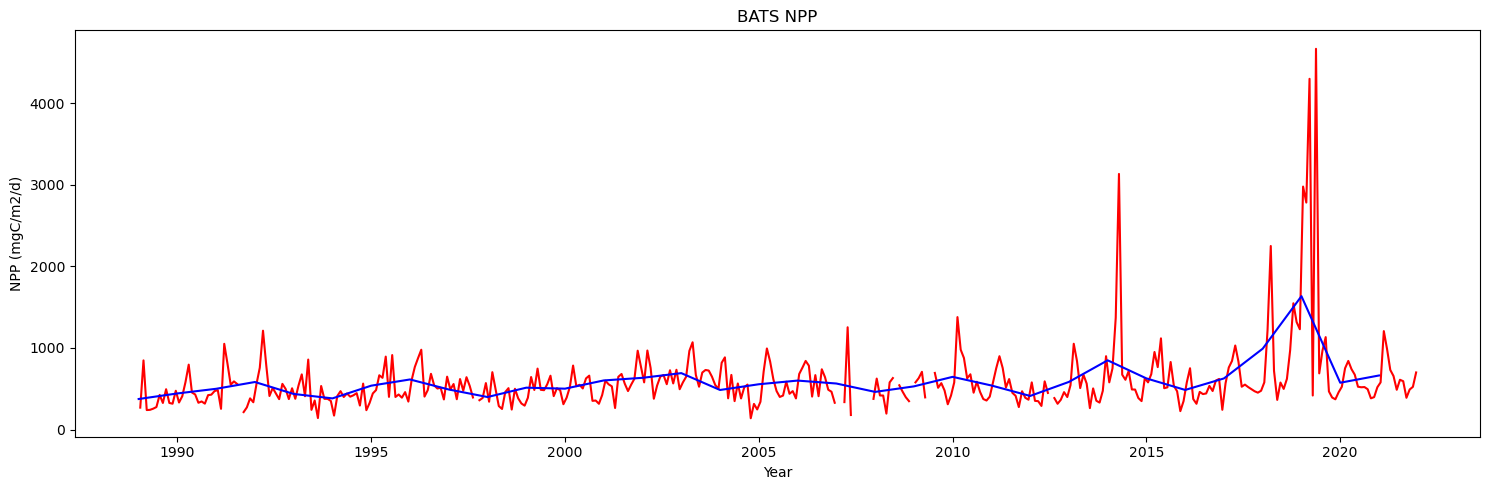

In [25]:
fig, ax1 = plt.subplots(figsize=(15,5))
plt.title('BATS NPP')
ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mgC/m2/d)')
npp = xr.DataArray(np.asarray(new_NPP_df2['NPP (mg/m2/d)']))
deciyear = xr.DataArray(np.asarray(new_NPP_df2['deciyear']))
ax1.plot(deciyear, npp, color='red',label='monthly NPP')

years = np.arange(1989,2022,1)
npp = xr.DataArray(np.asarray(annual_NPP_df['NPP (mg/m2/d)']))
ax1.plot(years, npp, color='blue',label='annual NPP')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

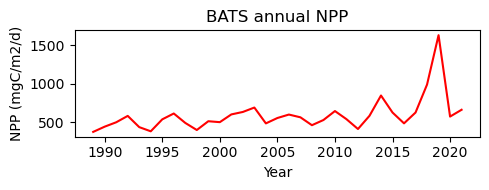

In [26]:
fig, ax1 = plt.subplots(figsize=(5,2))
plt.title('BATS annual NPP')
ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mgC/m2/d)')
years = np.arange(1989,2022,1)
npp = xr.DataArray(np.asarray(annual_NPP_df['NPP (mg/m2/d)']))
ax1.plot(years, npp, color='red',label='NPP')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Get a CESM run

In [27]:
import utils

In [28]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

In [29]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'
#path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1/'

In [30]:
variables = ['photoC_TOT_zint_100m','TEMP']

In [31]:
ds_fosi = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time','KMT'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi = xr.merge([ds_fosi,ds_tmp])

starting on  photoC_TOT_zint_100m
starting on  TEMP


In [32]:
ds_fosi = ds_fosi.isel(z_t=0)

In [33]:
ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

In [34]:
attrs = ds_fosi.photoC_TOT_zint_100m.attrs

ds_fosi['photoC_TOT_zint_100m'] = ds_fosi.photoC_TOT_zint_100m * 0.01 * 86400. * 12

In [35]:
attrs['units'] = 'mgC/m2/d'

In [36]:
ds_fosi['photoC_TOT_zint_100m'].attrs = attrs

In [37]:
ds_clim_fosi = ds_fosi.groupby('time.month').mean('time')

#### BATS lat/lon = 31.666667, -64.166667

In [38]:
ds_fosi

<xarray.Dataset>
Dimensions:               (d2: 2, nlat: 384, nlon: 320, time: 768, z_t_150m: 15)
Coordinates:
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                  (time) object 1958-01-16 13:00:00.000001 ... 2021-1...
    z_t                   float32 500.0
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                    float32 dask.array<chunksize=(), meta=np.ndarray>
    photoC_TOT_zint_100m  (time, nlat, nlon) float32 dask.array<chunksize=(768, 384, 320), meta=np.ndarray>
    time_bound            (time, d2) object dask.array<chunksize=(768, 2), meta=np.ndarray>
    TEMP                  (time, nlat, nlon) float32 dask.array<chunksize=(768, 384, 320), meta=np.ndarray>

In [39]:
ds_ann_fosi = ds_fosi.resample({'time':'A'}).mean(dim='time').compute()

In [40]:
box1_latmin = 30.5
box1_latmax = 32.5
box1_lonmin = -65.5
box1_lonmax = -63.5

In [41]:
lons_norm = utils.normal_lons(lons)

ts_box1 = xr.Dataset({v: ds_ann_fosi[v] for v in ['time']})
clim_box1 = xr.Dataset({v: ds_clim_fosi[v] for v in ['month']})

for var in variables:
    print(var)
    masked = ds_ann_fosi[var].where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    ts_box1[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

    masked = ds_clim_fosi[var].where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    clim_box1[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

photoC_TOT_zint_100m
TEMP


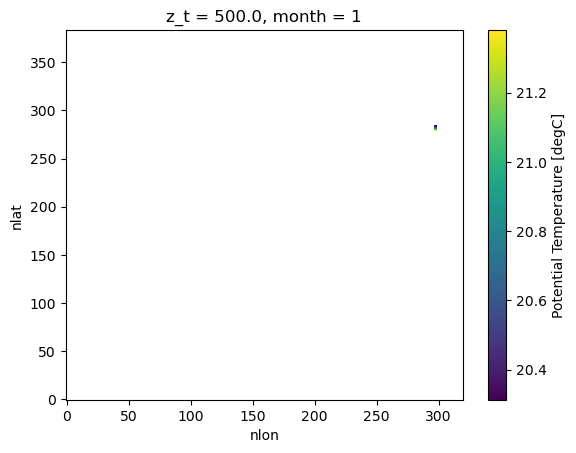

In [42]:
masked.isel(month=0).plot()

In [43]:
ts_box1['time'] = np.arange(1958,2022,1)

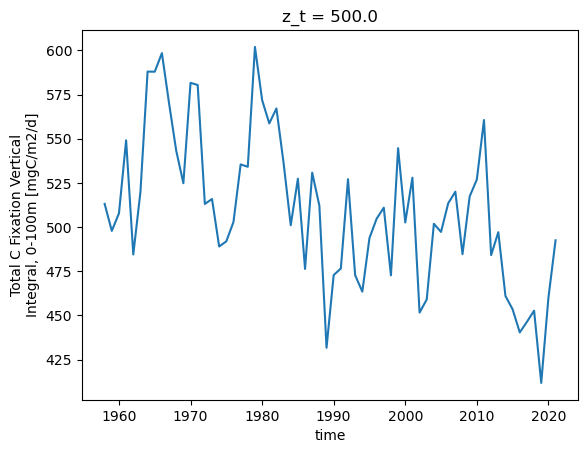

In [44]:
ts_box1.photoC_TOT_zint_100m.plot()

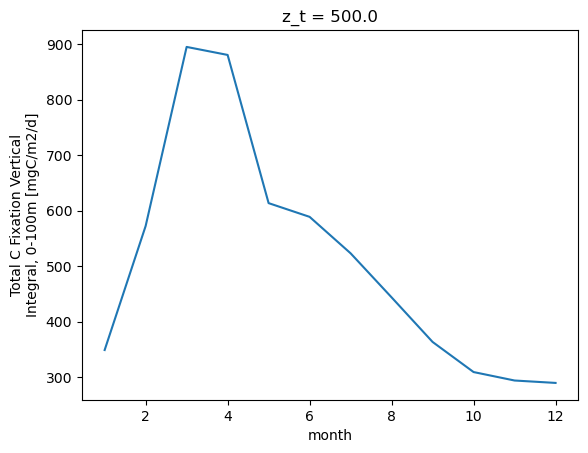

In [45]:
clim_box1.photoC_TOT_zint_100m.plot()

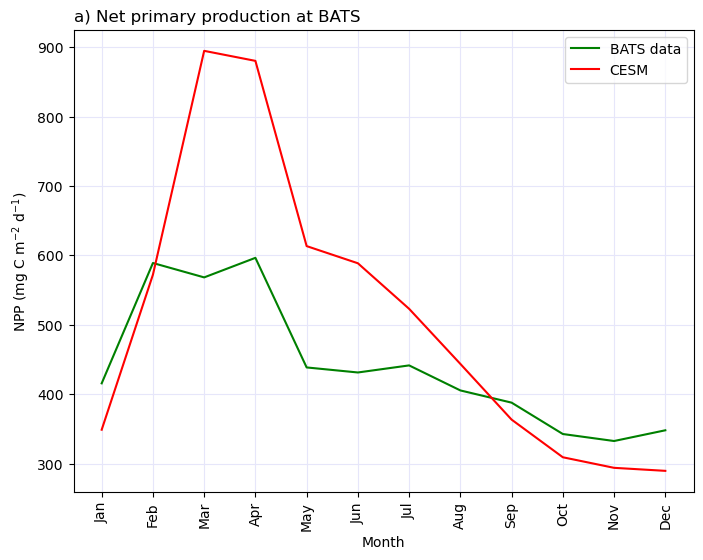

In [46]:
fig = plt.figure(figsize=(8,6))

######################################################## 

ax1 = fig.add_subplot(1,1,1)
ax1.set_title('a) Net primary production at BATS',fontsize=12,loc='left')
ax1.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.plot(xvals,NPP_monthly_clim_df['PP (mg/m2/d)'], 
         color='green', label='BATS data', lw=1.5)
error = NPP_monthly_clim_df['PP st dev (mg/m2/d)']
# ax1.fill_between(xvals, NPP_monthly_clim_df['PP (mg/m2/d)']-error, 
#                  NPP_monthly_clim_df['PP (mg/m2/d)']+error,color='paleturquoise', label = '1 SD')


ax1.plot(clim_box1.month, clim_box1.photoC_TOT_zint_100m, color='red', label='CESM')


plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()

### Get BATS temperature data (bottle)

In [47]:
csv_file = '/glade/work/kristenk/BATS/bats_bottle.csv'
df = pd.read_csv(csv_file)

In [48]:
df['date'] = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d')
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day']= df['date'].dt.day

In [49]:
df['Salt'] = df[['CTD_S','Sal1']].mean(axis=1)

In [50]:
df = df.drop(columns=['CTD_S','Sal1'])

In [51]:
df = df.replace(-999.,np.nan)

In [52]:
## 10 depth bins
d1s = [0,10,25,50,100,150,200,250,300,400]
d2s = [10,25,50,100,150,200,250,300,400,500]

In [53]:
column_names = ["month","Depth","Temp","Temp_sd","Salt","Salt_sd","O2","NO3"]

Monthly_clim_df = pd.DataFrame(columns = column_names)

for month in np.arange(1,13,1):
    
    for d in np.arange(0,10,1):

        selection = df[(df['Depth'] >= d1s[d]) & (df['Depth'] <d2s[d])]
        selection = selection[(df['month'] == month)]

        if (len(selection)==0):
            print('missing ', month, ' & depth ', d)

        else:

            temp = selection['Temp'].mean()
            sd_temp = selection['Temp'].std()
            
            salt = selection['Salt'].mean()
            sd_salt = selection['Salt'].std()

            o2 = selection['O2'].mean()
            no3 = selection['NO31'].mean()
            
            Monthly_clim_df = Monthly_clim_df.append({'month' : month, 'Depth' : (d1s[d] + d2s[d])/2,
                                                      'Temp' : temp, 'Temp_sd' : sd_temp,
                                                      'Salt' : salt, 'Salt_sd' : sd_salt,
                                                      'NO3' : no3,
                                                      'O2' : o2},  ignore_index = True)

Monthly_clim_df

,month,Depth,Temp,Temp_sd,Salt,Salt_sd,O2,NO3
0,1.0,5.0,20.978913,0.672296,-407.980687,180.591215,219.028947,0.078298
1,1.0,17.5,20.817266,0.574667,-384.464554,202.220744,219.623214,0.085741
2,1.0,37.5,20.790569,0.606430,-360.954527,219.293116,219.033333,0.225349
3,1.0,75.0,20.712174,0.559625,-374.429540,209.779880,218.844828,0.104940
4,1.0,125.0,20.218456,0.698589,-378.166653,206.994412,213.083871,0.620957
...,...,...,...,...,...,...,...,...
115,12.0,175.0,19.281135,0.545825,-398.059645,190.406996,199.324590,2.328182
116,12.0,225.0,18.845109,0.439727,-417.662135,170.409981,200.935484,2.948214
117,12.0,275.0,18.550986,0.488319,-355.461171,222.826178,195.915789,3.653250
118,12.0,350.0,18.296370,0.488375,-345.531366,228.475573,200.289362,4.234186


In [54]:
selection = Monthly_clim_df[(Monthly_clim_df['Depth'] == 5.)]
selection

,month,Depth,Temp,Temp_sd,Salt,Salt_sd,O2,NO3
0,1.0,5.0,20.978913,0.672296,-407.980687,180.591215,219.028947,0.078298
10,2.0,5.0,20.184651,0.625652,-420.021746,167.197352,221.937383,0.136974
20,3.0,5.0,19.887129,0.732668,-431.394201,152.710749,223.425000,0.157848
30,4.0,5.0,20.729879,0.815063,-432.900968,150.578249,223.582456,0.039540
40,5.0,5.0,22.094708,1.029991,-429.290183,155.550009,219.522619,0.043710
50,6.0,5.0,24.799321,1.119331,-442.214135,136.664064,210.549000,0.016731
60,7.0,5.0,27.167563,0.948527,-439.628739,140.796613,203.639450,0.042368
70,8.0,5.0,28.349303,0.734277,-441.295856,138.219775,198.763636,0.021667
80,9.0,5.0,27.882401,0.686635,-442.495524,136.297610,199.561176,0.008519
90,10.0,5.0,26.106552,0.701776,-430.049571,154.612261,204.355435,0.024706


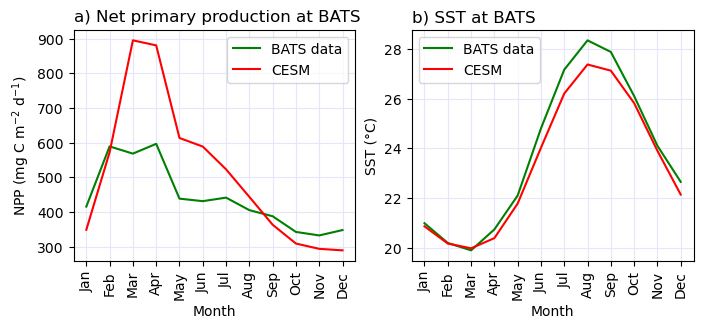

In [56]:
fig = plt.figure(figsize=(8,3))

######################################################## 

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('a) Net primary production at BATS',fontsize=12,loc='left')
ax1.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.plot(xvals,NPP_monthly_clim_df['PP (mg/m2/d)'], 
         color='green', label='BATS data', lw=1.5)

ax1.plot(clim_box1.month, clim_box1.photoC_TOT_zint_100m, color='red', label='CESM')

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()

#--------------------------

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('b) SST at BATS',fontsize=12,loc='left')
ax1.set_ylabel('SST (°C)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.plot(xvals,selection['Temp'], 
         color='green', label='BATS data', lw=1.5)
#error = NPP_monthly_clim_df['PP st dev (mg/m2/d)']
# ax1.fill_between(xvals, NPP_monthly_clim_df['PP (mg/m2/d)']-error, 
#                  NPP_monthly_clim_df['PP (mg/m2/d)']+error,color='paleturquoise', label = '1 SD')


ax1.plot(clim_box1.month, clim_box1.TEMP, color='red', label='CESM')


plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()